In [2]:
import numpy as np
import matplotlib.pyplot as plt
import qetpy as qp
from pprint import pprint

In [142]:
fs = 625e3

f = np.fft.fftfreq(32768, d=1/fs)


noisesim = qp.sim.TESnoise(r0=0.03) # r0 : bias resistance of the TES in Ohms

psd_sim = noisesim.s_iload(freqs=f) + noisesim.s_ites(freqs=f) + noisesim.s_itfn(freqs=f) 

f_fold, psd_sim_fold = qp.foldpsd(psd_sim, fs=fs) 




f_ = np.fft.fftfreq(1000, d=1/fs)
psd_sim_ = noisesim.s_iload(freqs=f_) + noisesim.s_ites(freqs=f_) + noisesim.s_itfn(freqs=f_) 


In [123]:
pulse_amp = 1.0e-6 
tau_f = 66e-6 
tau_r = 20e-6 

t = np.arange(len(psd_sim))/fs

pulse = np.exp(-t/tau_f)-np.exp(-t/tau_r)
pulse_shifted = np.roll(pulse, len(t)//2)
template = pulse_shifted/pulse_shifted.max()


noise = qp.gen_noise(psd_sim, fs=fs, ntraces=1)[0] 
signal = noise + np.roll(template, 100)*pulse_amp 
signal1 = signal + np.roll(template, 3000)*0.2e-6 
signal2 = noise + np.roll(template, 0)*pulse_amp + np.roll(template, 3000)*0.2e-6 

noise_psd = qp.calc_psd(noise, fs, False)
signal_psd = qp.calc_psd(signal, fs, False)
signal1_psd = qp.calc_psd(signal, fs, False)

/home/s/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<>:12: DeprecationWarning: invalid escape sequence \s
<>:12: DeprecationWarning: invalid escape sequence \s
<ipython-input-56-3caf4f9d5b8a>:12: DeprecationWarning: invalid escape sequence \s
  ax.set_ylabel("PSD [A/$\sqrt{\mathrm{Hz}}$]")


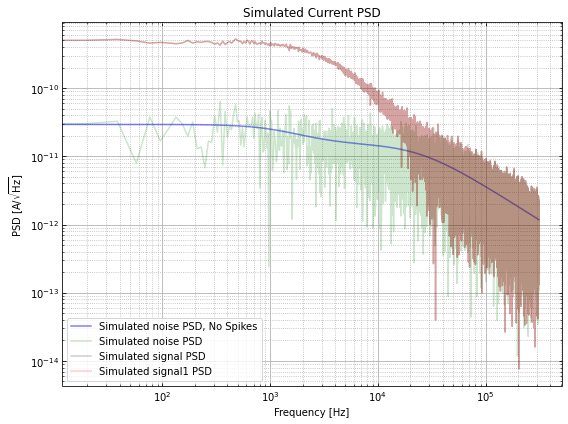

In [56]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.loglog(f_fold, psd_sim[:len(f_fold)]**0.5, color="blue", alpha=0.5, label="Simulated noise PSD, No Spikes")
ax.loglog(f_fold, noise_psd[1][:len(f_fold)]**0.5, color="green", alpha=0.2, label="Simulated noise PSD")
ax.loglog(f_fold, signal_psd[1][:len(f_fold)]**0.5, color="black", alpha=0.2, label="Simulated signal PSD")
ax.loglog(f_fold, signal1_psd[1][:len(f_fold)]**0.5, color="red", alpha=0.2, label="Simulated signal1 PSD")
# ax.set_ylim(1e-12,1e-9)
ax.grid()
ax.grid(which="minor", linestyle="dotted")
ax.tick_params(which="both", direction="in", right=True, top=True)
ax.legend(loc="best")
ax.set_title("Simulated Current PSD")
ax.set_ylabel("PSD [A/$\sqrt{\mathrm{Hz}}$]")
ax.set_xlabel("Frequency [Hz]")
fig.tight_layout()

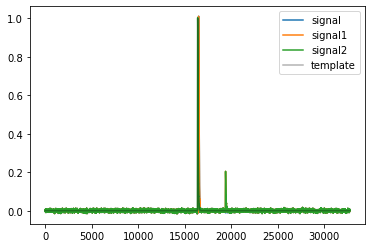

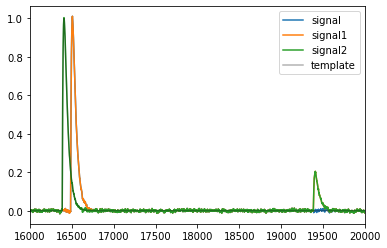

In [126]:
plt.plot(range(len(signal)), signal*1e6, label = 'signal')
plt.plot(range(len(signal)), signal1*1e6, label = 'signal1')
plt.plot(range(len(signal)), signal2*1e6, label = 'signal2')
plt.plot(range(len(signal)), template, color = 'black', alpha = 0.3, label = 'template')
# plt.xlim(26000,27000)
plt.legend()
plt.show()
plt.plot(range(len(signal)), signal*1e6, label = 'signal')
plt.plot(range(len(signal1)), signal1*1e6, label = 'signal1')
plt.plot(range(len(signal)), signal2*1e6, label = 'signal2')
plt.plot(range(len(signal)), template, color = 'black', alpha = 0.3, label = 'template')
plt.xlim(16000,20000)
plt.legend()

In [114]:
OF = qp.OptimumFilter(signal, template, psd_sim, fs)
amp_nodelay, chi2_nodelay = OF.ofamp_nodelay() 
amp_withdelay, t0_withdelay, chi2_withdelay = OF.ofamp_withdelay()

print(f"No Delay Fit: amp = {amp_nodelay*1e6:.2f} μA, χ^2 = {chi2_nodelay:.2f}")
print(f"With Delay Fit: amp = {amp_withdelay*1e6:.2f} μA, t_0 = {t0_withdelay*fs} bins, χ^2 = {chi2_withdelay:.2f}")
print('reduced chi2', chi2_withdelay/len(signal))

No Delay Fit: amp = -0.04 μA, χ^2 = 209963.39
With Delay Fit: amp = 1.00 μA, t_0 = 100.00000000000001 bins, χ^2 = 33023.69
reduced chi2 1.0078031786866672


/home/s/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [115]:
OF = qp.OptimumFilter(signal1, template, psd_sim, fs) 
amp_nodelay, chi2_nodelay = OF.ofamp_nodelay() 
amp_withdelay, t0_withdelay, chi2_withdelay = OF.ofamp_withdelay() 

print(f"No Delay Fit: amp = {amp_nodelay*1e6:.2f} μA, χ^2 = {chi2_nodelay:.2f}")
print(f"With Delay Fit: amp = {amp_withdelay*1e6:.2f} μA, t_0 = {t0_withdelay*fs} bins, χ^2 = {chi2_withdelay:.2f}")
print('reduced chi2', chi2_withdelay/len(signal1))

No Delay Fit: amp = -0.04 μA, χ^2 = 217024.14
With Delay Fit: amp = 1.00 μA, t_0 = 100.00000000000001 bins, χ^2 = 40197.30
reduced chi2 1.2267240998743763


In [138]:
OF = qp.OptimumFilter(signal2, template, psd_sim, fs) 
amp_nodelay, chi2_nodelay = OF.ofamp_nodelay() 
amp_withdelay, t0_withdelay, chi2_withdelay = OF.ofamp_withdelay(nconstrain =100, lgcoutsidewindow = False) 

print(f"No Delay Fit: amp = {amp_nodelay*1e6:.2f} μA, χ^2 = {chi2_nodelay:.2f}")
print(f"With Delay Fit: amp = {amp_withdelay*1e6:.2f} μA, t_0 = {t0_withdelay*fs} bins, χ^2 = {chi2_withdelay:.2f}")
print('reduced chi2', chi2_withdelay/len(signal2))

No Delay Fit: amp = 1.00 μA, χ^2 = 39897.10
With Delay Fit: amp = 1.00 μA, t_0 = 0.0 bins, χ^2 = 39897.10
reduced chi2 1.2175628025852703


In [144]:
OF = qp.OptimumFilter(signal2[16000:17000], template[16000:17000], psd_sim_, fs) 
amp_nodelay, chi2_nodelay = OF.ofamp_nodelay() 
amp_withdelay, t0_withdelay, chi2_withdelay = OF.ofamp_withdelay(nconstrain =100, lgcoutsidewindow = False) 

print(f"No Delay Fit: amp = {amp_nodelay*1e6:.2f} μA, χ^2 = {chi2_nodelay:.2f}")
print(f"With Delay Fit: amp = {amp_withdelay*1e6:.2f} μA, t_0 = {t0_withdelay*fs} bins, χ^2 = {chi2_withdelay:.2f}")
print('reduced chi2', chi2_withdelay/1000)

No Delay Fit: amp = 1.00 μA, χ^2 = 1015.99
With Delay Fit: amp = 1.00 μA, t_0 = 0.0 bins, χ^2 = 1015.99
reduced chi2 1.015988324411912


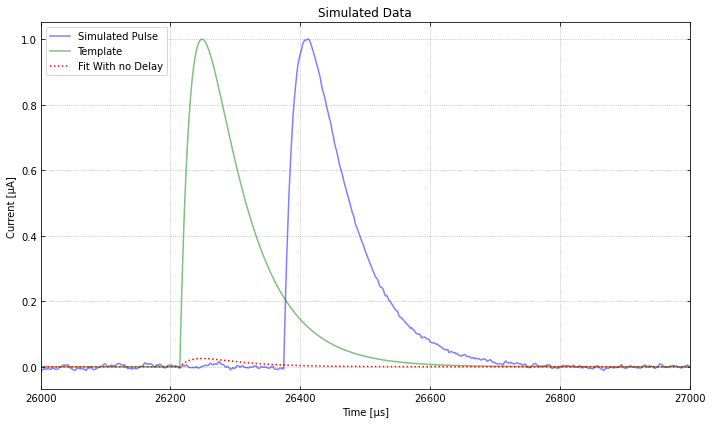

In [121]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(t*1e6, signal*1e6, label="Simulated Pulse", color="blue", alpha=0.5)
ax.plot(t*1e6, template, label="Template", color="green", alpha=0.5)
ax.plot(t*1e6, amp_nodelay*template*1e6, 
        label="Fit With no Delay", color="red", linestyle="dotted")
ax.set_ylabel("Current [μA]")
ax.set_xlabel("Time [μs]")
ax.set_xlim(26000,27000)
# plt.xlim(25000,30000)
ax.set_title("Simulated Data")
lgd = ax.legend(loc="upper left")
ax.tick_params(which="both", direction="in", right=True, top=True)
ax.grid(linestyle="dotted")
fig.tight_layout()

/home/s/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


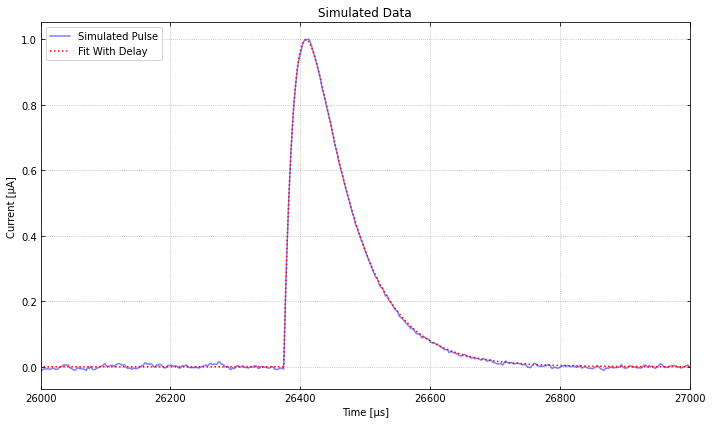

In [122]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(t*1e6, signal1*1e6, label="Simulated Pulse", color="blue", alpha=0.5)
ax.plot(t*1e6, amp_withdelay*np.roll(template, int(t0_withdelay*fs))*1e6, 
        label="Fit With Delay", color="red", linestyle="dotted")
ax.set_ylabel("Current [μA]")
ax.set_xlabel("Time [μs]")
ax.set_xlim(26000,27000)
ax.set_title("Simulated Data")
lgd = ax.legend(loc="upper left")
ax.tick_params(which="both", direction="in", right=True, top=True)
ax.grid(linestyle="dotted")
fig.tight_layout()

In [107]:
pileup = signal + np.roll(template, 10000)*pulse_amp

OF.update_signal(signal1) 
amp_withdelay, t0_withdelay, chi2_withdelay = OF.ofamp_withdelay(nconstrain=201) 
amp_pileup, t0_pileup, chi2_pileup = OF.ofamp_pileup_iterative(amp_withdelay, t0_withdelay) 

print(f"With Delay Fit: amp = {amp_withdelay*1e6:.2f} μA, t_0 = {t0_withdelay*fs} bins, χ^2 = {chi2_withdelay:.2f}")
print(f"Pileup Fit: amp = {amp_pileup*1e6:.2f} μA, t_0 = {t0_pileup*fs} bins, χ^2 = {chi2_pileup:.2f}")

With Delay Fit: amp = 1.00 μA, t_0 = 100.00000000000001 bins, χ^2 = 40197.30
Pileup Fit: amp = 0.20 μA, t_0 = 2999.9999999999995 bins, χ^2 = 33023.55


/home/s/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


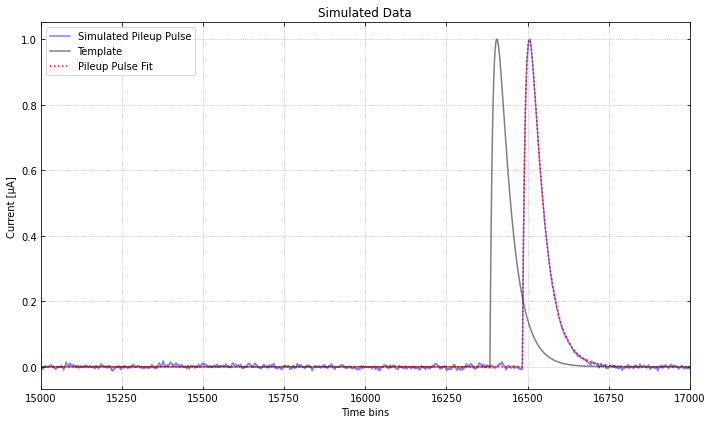

In [100]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(range(len(signal1)), signal1*1e6, label="Simulated Pileup Pulse", color="blue", alpha=0.5)
ax.plot(range(len(signal1)), template, label="Template", color="black", alpha=0.5)
ax.plot(range(len(signal1)), amp_withdelay*np.roll(template, int(t0_withdelay*fs))*1e6 + \
        amp_pileup*np.roll(template, int(t0_pileup*fs))*1e6, 
        label="Pileup Pulse Fit", color="red", linestyle="dotted")

ax.set_ylabel("Current [μA]")
ax.set_xlabel("Time bins")
ax.set_xlim(15000,17000)
ax.set_title("Simulated Data")
lgd = ax.legend(loc="upper left")
ax.tick_params(which="both", direction="in", right=True, top=True)
ax.grid(linestyle="dotted")
fig.tight_layout()

## Nonlinear Fitting

What about when we do not have a template? The `qetpy.OFnonlin` class has been written to fit the fall times as well, which is useful for cases where we do not have a template, or we know that the template will not match the data well.

In [12]:
pulse_amp = 1e-6
tau_f = 160e-6
tau_r = 20e-6

t = np.arange(len(psd_sim))/fs

pulse = np.exp(-t/tau_f)-np.exp(-t/tau_r)
pulse_shifted = np.roll(pulse, len(t)//2)
template = pulse_shifted/pulse_shifted.max()

noise = qp.gen_noise(psd_sim, fs=fs, ntraces=1)[0]
signal = noise + np.roll(template, 100)*pulse_amp



/home/s/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


We can try using our "bad" template (with a 66 us fall time), but we will see that the chi-squared indicates a non-ideal fit.

In [65]:
OF.update_signal(signal) # update the signal in order to fit a new trace
amp_withdelay, t0_withdelay, chi2_withdelay = OF.ofamp_withdelay(nconstrain=300)

print(f"With Delay Fit: amp = {amp_withdelay*1e6:.2f} μA, t_0 = {t0_withdelay*1e6:.2f} μs, χ^2 = {chi2_withdelay:.2f}")

With Delay Fit: amp = 1.00 μA, t_0 = 160.00 μs, χ^2 = 33023.69


/home/s/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Let's use `qetpy.OFnonlin` to do the fit. To help visualize the fit, we will use the parameter `lgcplot=True` to plot the fit in frequency domain and time domain

In [14]:
qp.OFnonlin?

In [15]:
qp.OFnonlin.fit_falltimes?

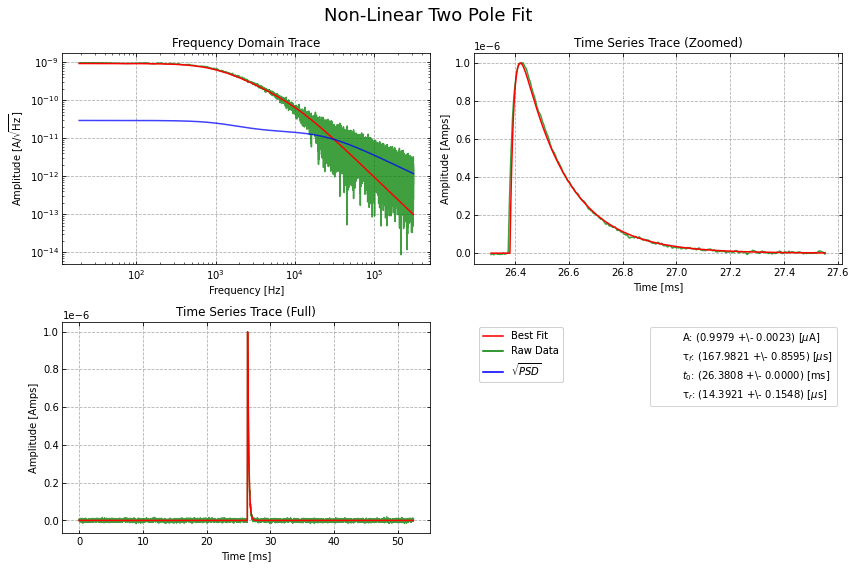

In [16]:
nonlinof = qp.OFnonlin(psd_sim, fs, template=None)
params, error, _, chi2_nonlin, success = nonlinof.fit_falltimes(signal, npolefit=2, lgcfullrtn=True, lgcplot=True)
# params :  best fit parameters ; error : The corresponding fit errors for the best fit parameters ; 
# _ : The convariance matrix returned from the fit ; success : The success flag from scipy.optimize.curve_fit i.e True if the fit converged. 

In [17]:
print(f"Nonlinear fit: χ^2 = {chi2_nonlin * (len(nonlinof.data)-nonlinof.dof):.2f}")
 

Nonlinear fit: χ^2 = 41221.77


/home/s/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


And we see that the fit using `qetpy.OFnonlin` is great! The chi-squared is near the number of degrees of freedom (32768), which indicates that we have a good fit.

For further documentation on the different fitting functions, please visit https://qetpy.readthedocs.io/en/latest/qetpy.core.html#module-qetpy.core._fitting.